In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller,acf,pacf 
from statsmodels.tsa.statespace.tools import diff
from pmdarima.arima import auto_arima 
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from sklearn.metrics import mean_squared_error 
import statsmodels.api as sm 
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns

## Data Reading and Preprocessing

In [2]:
df = pd.read_csv(r'C:\Users\anant\Downloads\DS3_C1_S5_SuperstoreSales_Data_Hackathon.csv',parse_dates=True)
print(len(df))
df

2121


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11-08-2016,11-11-2016,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11-08-2016,11-11-2016,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,731.9400,3,0.00,219.5820
2,4,US-2015-108966,10-11-2015,10/18/2015,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,06-09-2014,6/14/2014,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,06-09-2014,6/14/2014,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,9963,CA-2015-168088,3/19/2015,3/22/2015,First Class,Home Office,United States,Houston,Texas,77041,Central,Furniture,383.4656,4,0.32,-67.6704
2117,9965,CA-2016-146374,12-05-2016,12-10-2016,Second Class,Corporate,United States,Newark,Delaware,19711,East,Furniture,13.4000,1,0.00,6.4320
2118,9981,US-2015-151435,09-06-2015,09-09-2015,Second Class,Consumer,United States,Lafayette,Louisiana,70506,South,Furniture,85.9800,1,0.00,22.3548
2119,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,Consumer,United States,Miami,Florida,33180,South,Furniture,25.2480,3,0.20,4.1028


In [3]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [4]:
df = df.set_index("Order Date") 
df.head()

,Row ID,Order ID,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,
2016-11-08,1,CA-2016-152156,11-11-2016,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,261.9600,2,0.00,41.9136
2016-11-08,2,CA-2016-152156,11-11-2016,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,731.9400,3,0.00,219.5820
2015-10-11,4,US-2015-108966,10/18/2015,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,957.5775,5,0.45,-383.0310
2014-06-09,6,CA-2014-115812,6/14/2014,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,48.8600,7,0.00,14.1694
2014-06-09,11,CA-2014-115812,6/14/2014,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,1706.1840,9,0.20,85.3092


In [5]:
df.isnull().sum()

Row ID         0
Order ID       0
Ship Date      0
Ship Mode      0
Segment        0
Country        0
City           0
State          0
Postal Code    0
Region         0
Category       0
Sales          0
Quantity       0
Discount       0
Profit         0
dtype: int64

In [6]:
df=df.drop(['Row ID','Postal Code'],axis=1)
df

,Order ID,Ship Date,Ship Mode,Segment,Country,City,State,Region,Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,
2016-11-08,CA-2016-152156,11-11-2016,Second Class,Consumer,United States,Henderson,Kentucky,South,Furniture,261.9600,2,0.00,41.9136
2016-11-08,CA-2016-152156,11-11-2016,Second Class,Consumer,United States,Henderson,Kentucky,South,Furniture,731.9400,3,0.00,219.5820
2015-10-11,US-2015-108966,10/18/2015,Standard Class,Consumer,United States,Fort Lauderdale,Florida,South,Furniture,957.5775,5,0.45,-383.0310
2014-06-09,CA-2014-115812,6/14/2014,Standard Class,Consumer,United States,Los Angeles,California,West,Furniture,48.8600,7,0.00,14.1694
2014-06-09,CA-2014-115812,6/14/2014,Standard Class,Consumer,United States,Los Angeles,California,West,Furniture,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-19,CA-2015-168088,3/22/2015,First Class,Home Office,United States,Houston,Texas,Central,Furniture,383.4656,4,0.32,-67.6704
2016-12-05,CA-2016-146374,12-10-2016,Second Class,Corporate,United States,Newark,Delaware,East,Furniture,13.4000,1,0.00,6.4320
2015-09-06,US-2015-151435,09-09-2015,Second Class,Consumer,United States,Lafayette,Louisiana,South,Furniture,85.9800,1,0.00,22.3548


In [7]:
df=df.sort_values('Order Date')
df

,Order ID,Ship Date,Ship Mode,Segment,Country,City,State,Region,Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,
2014-01-06,CA-2014-167199,01-10-2014,Standard Class,Home Office,United States,Henderson,Kentucky,South,Furniture,2573.820,9,0.0,746.4078
2014-01-07,CA-2014-105417,01-12-2014,Standard Class,Consumer,United States,Huntsville,Texas,Central,Furniture,76.728,3,0.6,-53.7096
2014-01-10,CA-2014-149020,1/15/2014,Standard Class,Corporate,United States,Springfield,Virginia,South,Furniture,51.940,1,0.0,21.2954
2014-01-11,CA-2014-130092,1/14/2014,First Class,Consumer,United States,Dover,Delaware,East,Furniture,9.940,2,0.0,3.0814
2014-01-13,CA-2014-109232,1/16/2014,Second Class,Consumer,United States,Mount Pleasant,South Carolina,South,Furniture,545.940,6,0.0,87.3504
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-29,US-2017-158526,01-01-2018,Second Class,Consumer,United States,Louisville,Kentucky,South,Furniture,258.750,3,0.0,77.6250
2017-12-29,US-2017-158526,01-01-2018,Second Class,Consumer,United States,Louisville,Kentucky,South,Furniture,1207.840,8,0.0,314.0384
2017-12-29,CA-2017-146626,01-05-2018,Standard Class,Corporate,United States,Anaheim,California,West,Furniture,101.120,8,0.0,37.4144


In [8]:
dfs=df.resample('M').mean()
dfs

,Sales,Quantity,Discount,Profit
Order Date,,,,
2014-01-31,312.126250,3.500000,0.135000,40.273325
2014-02-28,262.808286,3.285714,0.114286,17.241671
2014-03-31,441.635030,3.969697,0.230303,-34.201667
2014-04-30,305.570654,3.115385,0.132692,21.322312
2014-05-31,288.032792,4.041667,0.256250,-14.578233
2014-06-30,440.204187,4.066667,0.157333,19.877177
2014-07-31,327.910636,3.454545,0.186364,11.340809
2014-08-31,305.014438,4.458333,0.131250,27.644654
2014-09-30,425.294300,3.714286,0.154821,33.189243


In [9]:
dfs.shape

(48, 4)

In [10]:
data=dfs['Sales']
data

Order Date
2014-01-31    312.126250
2014-02-28    262.808286
2014-03-31    441.635030
2014-04-30    305.570654
2014-05-31    288.032792
2014-06-30    440.204187
2014-07-31    327.910636
2014-08-31    305.014438
2014-09-30    425.294300
2014-10-31    384.507719
2014-11-30    347.820527
2014-12-31    414.134682
2015-01-31    782.662773
2015-02-28    284.943091
2015-03-31    446.420821
2015-04-30    317.445409
2015-05-31    312.498350
2015-06-30    296.699192
2015-07-31    341.860500
2015-08-31    301.206006
2015-09-30    437.883717
2015-10-31    334.072875
2015-11-30    401.049773
2015-12-31    360.715925
2016-01-31    346.488318
2016-02-29    206.607947
2016-03-31    312.221756
2016-04-30    377.488286
2016-05-31    351.624070
2016-06-30    343.962421
2016-07-31    335.090231
2016-08-31    430.456286
2016-09-30    328.468445
2016-10-31    247.345354
2016-11-30    392.390479
2016-12-31    436.651369
2017-01-31    248.501333
2017-02-28    264.089900
2017-03-31    286.669600
2017-04-30    

## Data Exploration

<AxesSubplot:xlabel='Order Date'>

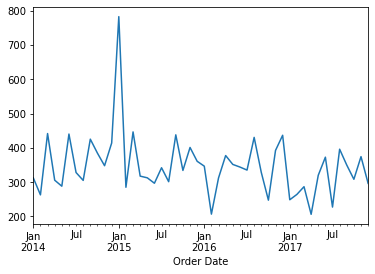

In [11]:
dfs['Sales'].plot()

Data shows Irregular or Random Component

## Check for stationarity

In [12]:
def checkStationarity(data):
    pvalue = adfuller(data)[1] 
    ''' output:-> 1) test statistic, 
    2) p-value, 
    3) number of lags, 
    4) total observations ''' 
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue) 
    else:
        msg='p-value={}. Data is stationary'.format(pvalue) 
    return(msg)

In [13]:
checkStationarity(data)

'p-value=9.093398510006677e-10. Data is stationary'

### Observation:
As the data is stationary shifting of the data is not necessary  

## Decomposition

Text(0.5, 1.0, 'Random')

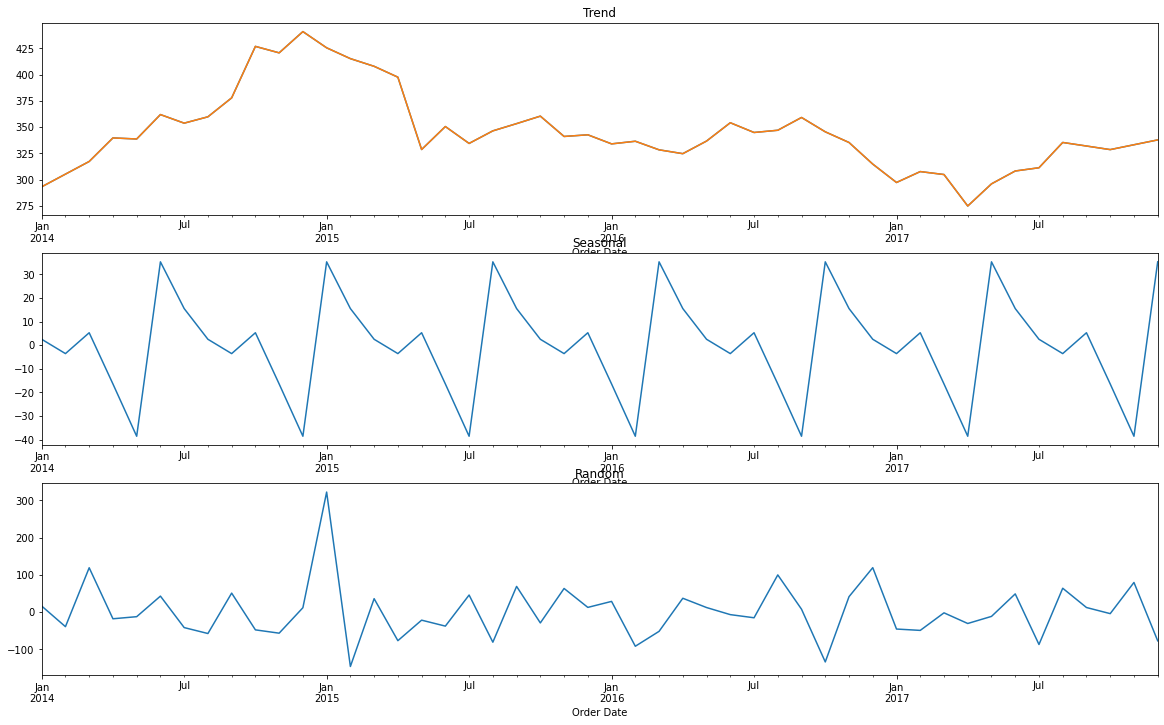

In [16]:
fig,ax = plt.subplots(3,1,figsize=(20,12)) 
result =seasonal_decompose(data, period=7, extrapolate_trend='freq') 
result.trend.plot(ax=ax[0]) 
result.trend.plot(ax=ax[0]) 
ax[0].set_title("Trend")
result.seasonal.plot(ax=ax[1]) 
ax[1].set_title("Seasonal")
result.resid.plot(ax=ax[2]) 
ax[2].set_title("Random")

## Observation:  
### From the above plots we can observe there is a seasonality in the dataset but no regular trend is observed  

## Splitting of data into Train and Test

In [14]:
ss = int(0.80 * len(dfs)) 
train_df = dfs.iloc[:ss] 
test_df = dfs.iloc[ss:]
print(train_df.head())
print(test_df.head())

                 Sales  Quantity  Discount     Profit
Order Date                                           
2014-01-31  312.126250  3.500000  0.135000  40.273325
2014-02-28  262.808286  3.285714  0.114286  17.241671
2014-03-31  441.635030  3.969697  0.230303 -34.201667
2014-04-30  305.570654  3.115385  0.132692  21.322312
2014-05-31  288.032792  4.041667  0.256250 -14.578233
                 Sales  Quantity  Discount     Profit
Order Date                                           
2017-03-31  286.669600  3.236842  0.137895  26.338242
2017-04-30  206.044502  3.977273  0.176591   4.601418
2017-05-31  319.953928  3.471698  0.192264  -1.375149
2017-06-30  372.717386  3.450980  0.192549  17.745012
2017-07-31  227.173500  3.519231  0.149038   6.242777


In [15]:
# split into train and test using relevant columns only
train = train_df.Sales
test = test_df.Sales
print("train= {}, test = {}".format(len(train), len(test)))

train= 38, test = 10


## Plotting ACF and PACF

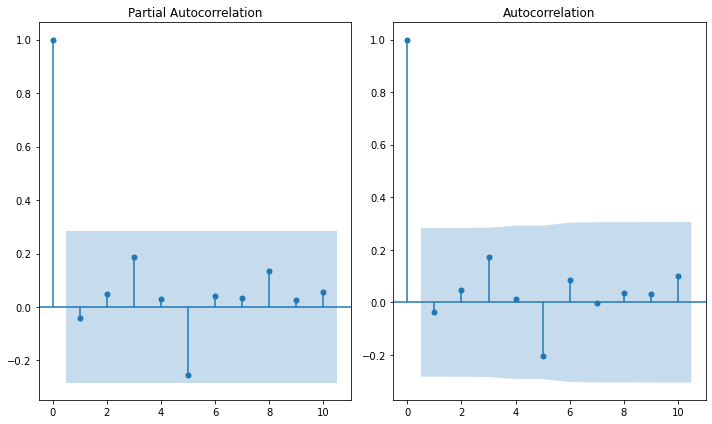

In [17]:
fig,ax=plt.subplots(1,2,figsize=(10,6)) 

# plot PACF (p) 
plot_pacf(data,lags=10,ax=ax[0])
 
# plot ACF (q)  
plot_acf(data,lags=10,ax=ax[1])

plt.tight_layout()

## Observation:
           From the PACF and ACF the values found for p and q are 1,1

# ARMA Model

In [18]:
p=1; q=1
m1 = ARIMA(train,order=(p,0,q)).fit() 
print(m1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -226.165
Date:                Wed, 02 Feb 2022   AIC                            460.331
Time:                        15:03:04   BIC                            466.881
Sample:                    01-31-2014   HQIC                           462.661
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        355.3006     21.432     16.578      0.000     313.295     397.306
ar.L1          0.0416      2.784      0.015      0.988      -5.414       5.498
ma.L1         -0.1153      2.775     -0.042      0.9

### Box-Jenkins test to check model's goodness

In [19]:
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values 
if pvalue < 0.05:
    print("Reject H0. Bad model") 
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


### Predict the test data using the model

In [20]:
predictions = m1.predict(0,len(test)-1) 
print(predictions)

Order Date
2014-01-31    355.300572
2014-02-28    358.454837
2014-03-31    362.478623
2014-04-30    349.767050
2014-05-31    358.326642
2014-06-30    360.606025
2014-07-31    349.656509
2014-08-31    356.667825
2014-09-30    359.163467
2014-10-31    350.588744
Freq: M, Name: predicted_mean, dtype: float64


### Collate actual, predicted, and errors together

In [21]:
actual = []; 
pred = [] 
for i in range(len(predictions)):
    actual.append(test[i]) 
    pred.append(predictions[i]) 
df_res = pd.DataFrame({'actual':actual, 'predicted':pred}) 
df_res['err'] = df_res.actual -df_res.predicted 
print(df_res)

       actual   predicted         err
0  286.669600  355.300572  -68.630972
1  206.044502  358.454837 -152.410335
2  319.953928  362.478623  -42.524695
3  372.717386  349.767050   22.950336
4  227.173500  358.326642 -131.153142
5  395.945487  360.606025   35.339462
6  349.737422  349.656509    0.080912
7  308.226313  356.667825  -48.441513
8  374.310253  359.163467   15.146785
9  296.296857  350.588744  -54.291887


### Plot actual vs. predicted values

<AxesSubplot:>

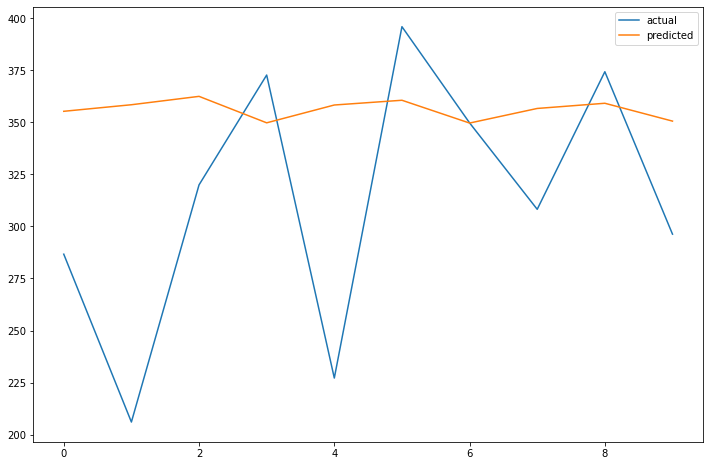

In [22]:
df_res[['actual','predicted']].plot(figsize=(12,8))

### Calculate Error Terms

In [23]:
mse1=mean_squared_error(df_res.actual,df_res.predicted)
print("\n\tMSE= {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))


	MSE= 5424.783316451074
	RMSE = 73.6531283548165


### Plot Errors

<AxesSubplot:>

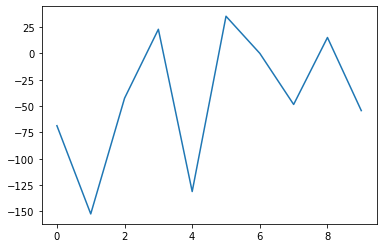

In [24]:
df_res['err'].plot()

### Forecast the future data using the model

In [25]:
fcast= m1.predict(start=len(data), end=len(data)+12)
print(fcast)

2018-01-31    355.300572
2018-02-28    355.300572
2018-03-31    355.300572
2018-04-30    355.300572
2018-05-31    355.300572
2018-06-30    355.300572
2018-07-31    355.300572
2018-08-31    355.300572
2018-09-30    355.300572
2018-10-31    355.300572
2018-11-30    355.300572
2018-12-31    355.300572
2019-01-31    355.300572
Freq: M, Name: predicted_mean, dtype: float64


<AxesSubplot:xlabel='Order Date'>

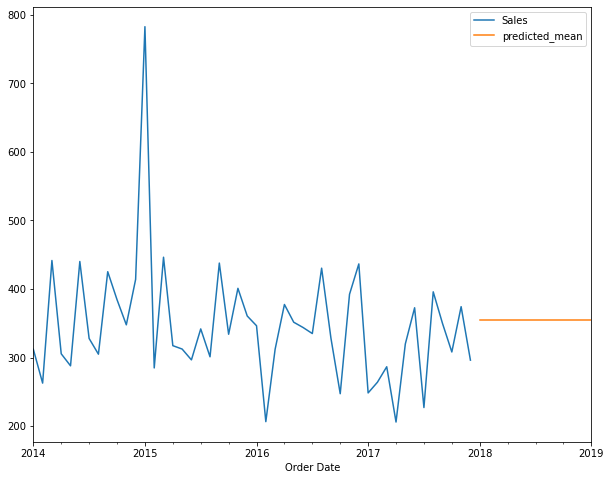

In [26]:
data.plot(figsize=(10,8),legend=True) 
fcast.plot(legend=True) 

# ARIMA Model

In [27]:
p=1; d=1; q=1 
m_arima = ARIMA(train,order=(p,d,q)).fit()
print(m_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -222.597
Date:                Wed, 02 Feb 2022   AIC                            451.194
Time:                        15:03:04   BIC                            456.027
Sample:                    01-31-2014   HQIC                           452.898
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0466      0.239     -0.195      0.845      -0.515       0.421
ma.L1         -0.9902      0.987     -1.003      0.316      -2.925       0.944
sigma2      8977.3070   8031.166      1.118      0.2

### Box-Jenkins test to check model's goodness

In [28]:
pvalue = sm.stats.acorr_ljungbox(m_arima.resid,lags=[1],return_df=True)['lb_pvalue'].values 
if pvalue < 0.05:
    print("Reject H0. Bad model") 
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


### Predict the test data using the model

In [29]:
predictions = m_arima.predict(0,len(test)-1) 
print(predictions)

Order Date
2014-01-31      0.000000
2014-02-28    309.136373
2014-03-31    287.300377
2014-04-30    331.838988
2014-05-31    331.471055
2014-06-30    323.453513
2014-07-31    336.106838
2014-08-31    340.149710
2014-09-30    336.772116
2014-10-31    341.117030
Freq: M, Name: predicted_mean, dtype: float64


### Collate actual, predicted, and errors together

In [30]:
actual = []; 
pred = [] 
for i in range(len(predictions)):
    actual.append(test[i]) 
    pred.append(predictions[i]) 
df_res = pd.DataFrame({'actual':actual, 'predicted':pred}) 
df_res['err'] = df_res.actual -df_res.predicted 
print(df_res)

       actual   predicted         err
0  286.669600    0.000000  286.669600
1  206.044502  309.136373 -103.091871
2  319.953928  287.300377   32.653551
3  372.717386  331.838988   40.878398
4  227.173500  331.471055 -104.297555
5  395.945487  323.453513   72.491974
6  349.737422  336.106838   13.630584
7  308.226313  340.149710  -31.923398
8  374.310253  336.772116   37.538137
9  296.296857  341.117030  -44.820174


### Plot actual vs. Predicted values

<AxesSubplot:>

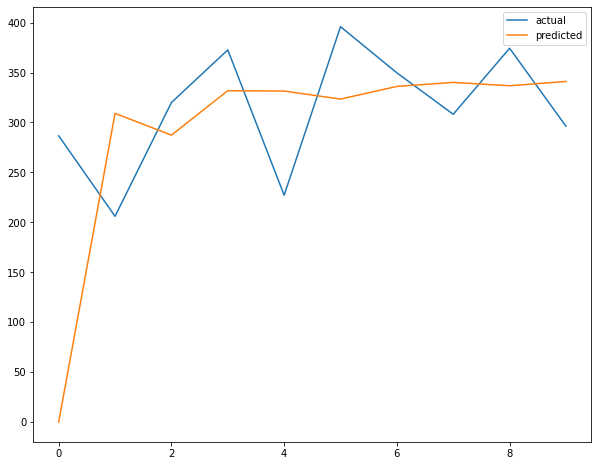

In [31]:
df_res.actual.plot(figsize=(10,8),legend=True) 
df_res.predicted.plot(legend=True)

### Calculate Error terms

In [32]:
mse1=mean_squared_error(df_res.actual,df_res.predicted)
print("\n\tMSE= {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))


	MSE= 11630.061338938118
	RMSE = 107.84276210732975


### Plot the Errors 

<AxesSubplot:>

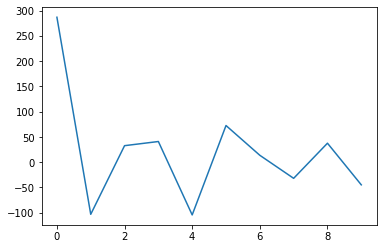

In [33]:
df_res['err'].plot()

### Forecast the future data using the model

In [34]:
fcast= m_arima.predict(start=len(data), end=len(data)+12, typ='levels').rename('Forecast')
print(fcast)

2018-01-31    354.845709
2018-02-28    354.845709
2018-03-31    354.845709
2018-04-30    354.845709
2018-05-31    354.845709
2018-06-30    354.845709
2018-07-31    354.845709
2018-08-31    354.845709
2018-09-30    354.845709
2018-10-31    354.845709
2018-11-30    354.845709
2018-12-31    354.845709
2019-01-31    354.845709
Freq: M, Name: Forecast, dtype: float64


<AxesSubplot:xlabel='Order Date'>

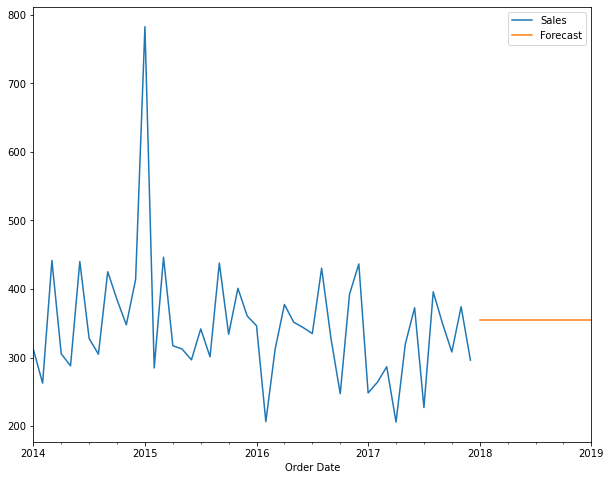

In [35]:
dfs['Sales'].plot(figsize=(10,8),legend=True) 
fcast.plot(legend=True)

## Observation on Forecast

As there is no trend in the data the forecast plot of ARMA and ARIMA gives a straight line

# SARIMA Model

In [36]:
from pandas.plotting import autocorrelation_plot  
from pandas.tseries.offsets import DateOffset

In [37]:
p=1; q=1; d=1
m_sarima= sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   38
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -158.247
Date:                            Wed, 02 Feb 2022   AIC                            326.495
Time:                                    15:03:05   BIC                            332.589
Sample:                                01-31-2014   HQIC                           328.185
                                     - 02-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0198      0.352      0.056      0.955      -0.670       0.710
ma.L1         -0.9997    150.918   

### Box-Jenkins test to check model's goodness

In [38]:
pvalue = sm.stats.acorr_ljungbox(m_sarima.resid,lags=[1],return_df=True)['lb_pvalue'].values 
if pvalue < 0.05:
    print("Reject H0. Bad model") 
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


### Use the model for Predictions 

In [39]:
predictions = m_sarima.predict(0,len(test)-1) 
print(predictions)

Order Date
2014-01-31      0.000000
2014-02-28    309.361354
2014-03-31    263.563911
2014-04-30    438.549194
2014-05-31    307.825132
2014-06-30    288.422091
2014-07-31    437.568872
2014-08-31    329.767955
2014-09-30    305.482272
2014-10-31    423.217780
Freq: M, Name: predicted_mean, dtype: float64


### Collate actual, predicted, and errors together

In [40]:
actual = []; 
pred = [] 
for i in range(len(predictions)):
    actual.append(test[i]) 
    pred.append(predictions[i]) 
df_res = pd.DataFrame({'actual':actual, 'predicted':pred}) 
df_res['err'] = df_res.actual -df_res.predicted 
print(df_res)

       actual   predicted         err
0  286.669600    0.000000  286.669600
1  206.044502  309.361354 -103.316851
2  319.953928  263.563911   56.390017
3  372.717386  438.549194  -65.831808
4  227.173500  307.825132  -80.651632
5  395.945487  288.422091  107.523397
6  349.737422  437.568872  -87.831451
7  308.226313  329.767955  -21.541642
8  374.310253  305.482272   68.827981
9  296.296857  423.217780 -126.920923


### Plot actual vs. Predicted values

<AxesSubplot:>

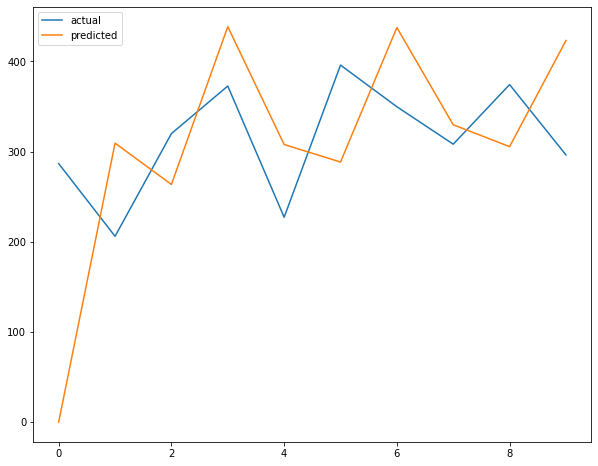

In [41]:
df_res.actual.plot(figsize=(10,8),legend=True) 
df_res.predicted.plot(legend=True)

### Calculate Error terms

In [42]:
mse1=mean_squared_error(df_res.actual,df_res.predicted)
print("\n\tMSE= {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))


	MSE= 14745.80766894049
	RMSE = 121.432317234501


### Plot the Errors

<AxesSubplot:>

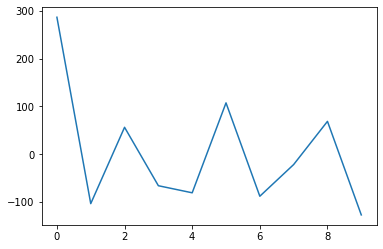

In [43]:
df_res['err'].plot()

### Forecast the future data using the model

In [44]:
fcast= m_sarima.predict(start=len(data), end=len(data)+12, typ='levels').rename('Forecast')
print(fcast)

2018-01-31    382.462333
2018-02-28    217.362895
2018-03-31    353.812113
2018-04-30    287.892930
2018-05-31    271.786573
2018-06-30    314.426624
2018-07-31    289.255748
2018-08-31    299.984316
2018-09-30    350.957794
2018-10-31    276.544720
2018-11-30    334.419574
2018-12-31    355.872621
2019-01-31    368.160915
Freq: M, Name: Forecast, dtype: float64


<AxesSubplot:xlabel='Order Date'>

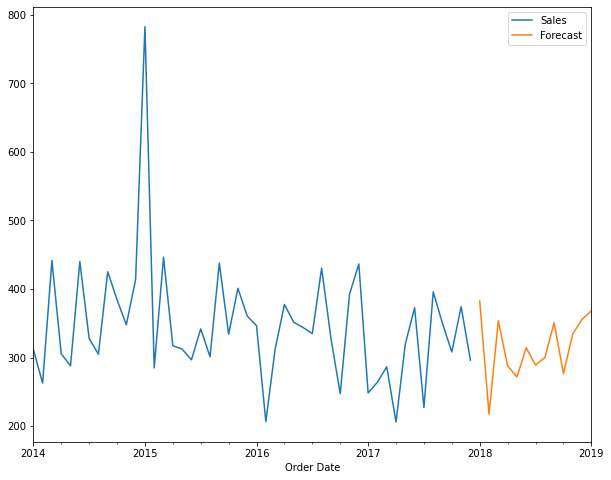

In [45]:
dfs['Sales'].plot(figsize=(10,8),legend=True) 
fcast.plot(legend=True)

# SARIMAX Model

### Split Exogenous data into train and test parts

In [58]:
exog_train = train_df[['Quantity','Discount']] 
exog_test =test_df[['Quantity','Discount']]
print('exog_train = {}, train_df = {}'.format( len(exog_train), len(train_df)))

exog_train = 38, train_df = 38


### Build the SARIMAX model

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_exo = SARIMAX(train_df.Sales,order=(2,0,1),seasonal_order=(1,0,0,7),exog = exog_train.values).fit()
print(model_exo.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   38
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 7)   Log Likelihood                -216.298
Date:                            Wed, 02 Feb 2022   AIC                            446.596
Time:                                    15:17:57   BIC                            458.059
Sample:                                01-31-2014   HQIC                           450.675
                                     - 02-28-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            85.6355     17.099      5.008      0.000      52.122     119.149
x2           135.1392    388.724   

### Forecast using the model

In [54]:
test_df

,Sales,Quantity,Discount,Profit
Order Date,,,,
2017-03-31,286.669600,3.236842,0.137895,26.338242
2017-04-30,206.044502,3.977273,0.176591,4.601418
2017-05-31,319.953928,3.471698,0.192264,-1.375149
2017-06-30,372.717386,3.450980,0.192549,17.745012
2017-07-31,227.173500,3.519231,0.149038,6.242777
2017-08-31,395.945487,3.256410,0.148718,8.262538
2017-09-30,349.737422,3.638554,0.156024,18.658840
2017-10-31,308.226313,3.549296,0.187606,-35.590427
2017-11-30,374.310253,3.676768,0.165556,4.101654


In [55]:
forecast_exo = model_exo.forecast(len(test_df), exog=exog_test.values) 
forecast_exo

2017-03-31    303.733282
2017-04-30    360.563686
2017-05-31    323.717048
2017-06-30    321.751048
2017-07-31    321.673699
2017-08-31    298.681810
2017-09-30    332.655909
2017-10-31    329.334060
2017-11-30    337.220140
2017-12-31    341.662328
Freq: M, Name: predicted_mean, dtype: float64

### Plot actual vs. Predicted values

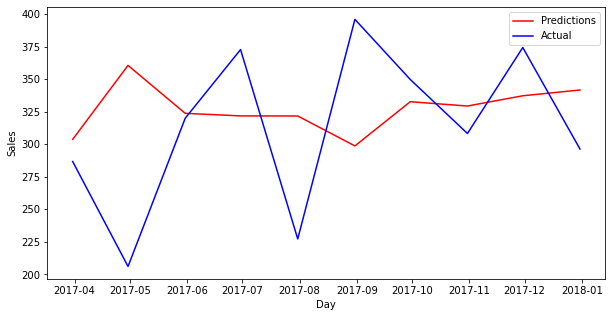

In [56]:
plt.figure(figsize=(10,5)) 
plt.plot(forecast_exo, 'r', label = 'Predictions') 
plt.plot(test_df.Sales, 'b', label='Actual') 
plt.xlabel('Day') 
plt.ylabel('Sales')
plt.legend() 

### Calculate Error terms

In [57]:
mse1 = mean_squared_error(test_df.Sales,forecast_exo) 
print('RMSE: ' + str(np.sqrt(mse1) ))

RMSE: 70.24286735970927


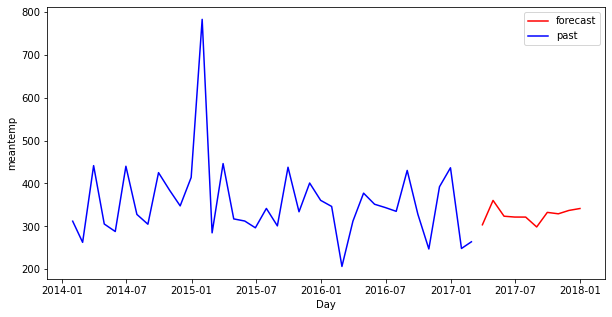

In [61]:
plt.figure(figsize=(10,5))
plt.plot(forecast_exo, 'r', label = 'forecast')
plt.plot(train, 'b', label='past')
plt.xlabel('Day')
plt.ylabel('meantemp')
plt.legend()
plt.show()

We cannot forecast for SARIMAX as we don't have Exogenous test values

# Observations and Conclusion:

### ARMA Model(1,0,1):  
    AIC  460.331  
    RMSE 73.6531351053026     
        
### ARIMA Model(1,1,1):  
    AIC  451.194  
    RMSE 107.84276220584547 
    
### SARIMA Model[(1, 1, 1)x(1, 1, 1, 12)]:  
    AIC  326.495  
    RMSE 121.432320180903    
       
### SARIMAX Model:  
    AIC  446.596  
    RMSE 70.24286735970927  

### SARIMAX with Exogenous splitting is best model for this dataset . Next preferred model would be ARMA as the data is stationary no differencing of data is necessary